In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nbodykit.algorithms import FFTPower
from glob import glob
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import site
site.addsitedir('/home/users/mahlet/illustris_python/') 
import illustris_python as il
import pmesh
from mpi4py import MPI

plt.rcParams['figure.dpi'] = 85
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 4.32
plt.rcParams['ytick.minor.size'] = 2.46
plt.rcParams['xtick.major.width'] = 1.6
plt.rcParams['xtick.minor.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.6
plt.rcParams['ytick.minor.width'] = 1.2

/home/groups/tabel/mahlet/nbody-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load galaxy catalogues (data available upon request)
### Define some functions

In [2]:
def zero(params, offset = 1e-13):
    
    # Now add an offset to avoid numerical errors
    return [i + offset for i in params]

In [3]:
def halos_um_z(K, fdir = '/oak/stanford/orgs/kipac/users/chto/buzzard_redmapper/L205n2500TNG_DM/sfrca/'):

    # First, view the options in UM
    catalogs = glob(fdir + 'sfr_catalog_*')

    lst=[]
    for cat in catalogs:
        lst.append(1./float(cat[-12:-4]) - 1)
        
    # find the catalog closest to z = 0!
    z = min(range(len(lst)), key = lambda i: abs(lst[i]-K))
    dtype = np.dtype(dtype=[('id', 'i8'),('descid','i8'),('upid','i8'),
                            ('flags', 'i4'), ('uparent_dist', 'f4'),
                            ('pos', 'f4', (6)), ('vmp', 'f4'), ('lvmp', 'f4'),
                            ('mp', 'f4'), ('m', 'f4'), ('v', 'f4'), ('r', 'f4'),
                            ('rank1', 'f4'), ('rank2', 'f4'), ('ra', 'f4'),
                            ('rarank', 'f4'), ('A_UV', 'f4'), ('sm', 'f4'),
                            ('icl', 'f4'), ('sfr', 'f4'), ('obs_sm', 'f4'),
                            ('obs_sfr', 'f4'), ('obs_uv', 'f4'), ('empty', 'f4')],
                     align=True)
    halos = np.fromfile(catalogs[z], dtype=dtype)

    # keep pos in cMpc/h, let us convert from UM solar mass --> solar mass / h (where h = 0.678 according to Planck 2016) and keep pos in cMpc/h
    return zero((halos['sm'] * 0.678, halos['sfr'], halos['m'])), halos['pos'][:,:3]

In [4]:
def halos_tng_z(z, snapvec = {0: 99, 0.5: 67, 1: 50, 1.5: 40}, basePath = '/oak/stanford/orgs/kipac/users/mahlet/TNG300-1/output'):
    
    # Then, load galaxy catalogues in TNG
    fields = ['SubhaloMassType','SubhaloSFR', 'SubhaloGrNr', 'SubhaloPos', 'SubhaloVmax', 'SubhaloFlag']
    a = 1/(1+z)
    snapshot = snapvec[z]
    subhalos = il.groupcat.loadSubhalos(basePath, snapshot, fields = fields)

    fields_tng = [subhalos[i] for i in fields] 
    flag = fields_tng[-1]
    sm_tng_zero, sfr_tng_zero, grnr, pos_tng, vmax_tng = [field[flag] for field in fields_tng[:-1]] 
    sm_tng_zero = sm_tng_zero[:,4]*10**10
    pos_tng /= 1000 # ckpc/h --> cMpc/h
    print(fields[:-1])
    
    fields = ['Group_M_Crit200', 'GroupPos']
    halos_tng = il.groupcat.loadHalos(basePath, snapshot, fields = fields) 
    m_tng_zero, pos_tng_halo = [halos_tng[i] for i in fields]
    m_tng_zero*=10**10
    print(fields)

    return zero((sm_tng_zero, sfr_tng_zero, m_tng_zero)), grnr, pos_tng

In [5]:
sm_um, sfr_um, m_um, pos_um = dict(), dict(), dict(), dict()
sm_tng, sfr_tng, m_tng, grnr, pos_tng = dict(), dict(), dict(), dict(), dict()

for z in [0,0.5,1,1.5]:
    (sm_um[z], sfr_um[z], m_um[z]), pos_um[z] = halos_um_z(z)
    (sm_tng[z], sfr_tng[z], m_tng[z]), grnr[z], pos_tng[z] = halos_tng_z(z)

['SubhaloMassType', 'SubhaloSFR', 'SubhaloGrNr', 'SubhaloPos', 'SubhaloVmax']
['Group_M_Crit200', 'GroupPos']
['SubhaloMassType', 'SubhaloSFR', 'SubhaloGrNr', 'SubhaloPos', 'SubhaloVmax']
['Group_M_Crit200', 'GroupPos']
['SubhaloMassType', 'SubhaloSFR', 'SubhaloGrNr', 'SubhaloPos', 'SubhaloVmax']
['Group_M_Crit200', 'GroupPos']
['SubhaloMassType', 'SubhaloSFR', 'SubhaloGrNr', 'SubhaloPos', 'SubhaloVmax']
['Group_M_Crit200', 'GroupPos']


### Make galaxy cuts! 

In [6]:
cuts = {0: {'high': {'TNG': [-10.211, 10.156], 'UM': [-10.121, 10.316]}, 
         'low': {'TNG': [-11.664, 10.81], 'UM': [-10.713, 10.889]}, 
         'medium':{'TNG': [-11.254, 10.396], 'UM': [-10.253, 10.534]}}, 
        0.5: {'high': {'TNG': [-10.394, 10.108], 'UM': [-11.156, 10.3]}, 
         'low': {'TNG': [-11.68, 10.758], 'UM': [-11.488, 10.829]}, 
         'medium':{'TNG': [-11.46, 10.372], 'UM': [-11.31, 10.509]}}, 
        1: {'high': {'TNG': [-9.591, 9.998], 'UM': [-9.846, 10.183]}, 
         'low': {'TNG': [-10.86, 10.688], 'UM': [-11.337, 10.763]}, 
         'medium':{'TNG': [-10.172, 10.286], 'UM': [-11.02, 10.426]}},
        1.5: {'high': {'TNG': [-9.253, 9.862], 'UM': [-9.141, 9.863]}, 
         'low': {'TNG': [-10.339, 10.606], 'UM': [-10.964, 10.665]}, 
         'medium':{'TNG': [-9.4, 10.145], 'UM': [-9.421, 10.213]}}}

In [7]:
def cuts_z(z, color, density, hodtype, sfr, sm, Lbox = 205):
    
    # define variables
    volume = Lbox**3 #Mpc/h
    ssfr = sfr[z]/sm[z]
    ssfr_log, sm_log = np.log10(ssfr), np.log10(sm[z])
    
    ssfr_cut, sm_cut = cuts[z][density][hodtype]
    print(sm_cut)
    
    # red galaxies in UM
    if color == 'red':
        ind = np.where((ssfr_log < ssfr_cut) & (sm_log > sm_cut))[0]
        cut = len(ind)/volume
        print("{:.2e}, {:.2e}".format(cut/5e-4, cut)) 
    
    # blue galaxies in UM
    elif color == 'blue':
        ind = np.where((ssfr_log > ssfr_cut) & (sm_log > sm_cut))[0]
        cut = len(ind)/volume
        print("{:.2e}, {:.2e}".format(cut/5e-4, cut)) 
        
    else:
        ind = np.where(sm_log > sm_cut)[0]
        cut = len(ind)/volume
        print("{:.2e}, {:.2e}".format(cut/10e-4, cut)) 
    
    return ssfr_cut, sm_cut, cut, ssfr, ind

# Figure 1: Visualize the HEFT fields
### Define some global variables

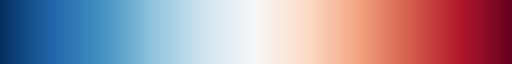

In [8]:
cmap = sns.color_palette("RdBu_r", as_cmap = True)
cmap

In [9]:
z = 0.5          # chooose redshift to visualize fields at
density = 'high' # choose number density cut for galaxy samples

In [10]:
Nmesh = 1250           # resolution
Lbox = 205             # box size
comm = MPI.COMM_WORLD  # MPI

In [11]:
home = '/oak/stanford/orgs/kipac/users/mahlet/' # directory to save files
Ndown = 5                                       # downsampling factor

### Define some functions

In [12]:
def downsample(array, Nmesh = Nmesh, Ndown = Ndown):

    array = np.reshape(array, (Nmesh//Ndown,Ndown, Nmesh//Ndown, Ndown, Nmesh//Ndown, Ndown))

    array = np.sum(array, axis=1)/Ndown
    array = np.sum(array, axis=2)/Ndown
    array = np.sum(array, axis=3)/Ndown

    return array

In [13]:
def make_gal_mesh(color, d, density = density, Nmesh = Nmesh, Ndown = Ndown, cmap = cmap, z = z, sfr_tng = sfr_tng, sm_tng = sm_tng, 
                  pos_tng = pos_tng, home = home, comm = comm):

    ssfr_cut, sm_cut, cut_red, ssfr, red_ind_tng = cuts_z(z, color, density, 'TNG', sfr_tng, sm_tng)

    res = Nmesh/Ndown
    pm = pmesh.pm.ParticleMesh([Nmesh, Nmesh, Nmesh], Lbox, dtype='float32', resampler='cic', comm=comm)
    hodslice = pos_tng[z][red_ind_tng]
    layout = pm.decompose(hodslice)
    p = layout.exchange(hodslice)
    print('p: '+str(np.shape(p)))
    
    gal_field = pm.create(type='real')
    print('gal_field: '+str(np.shape(gal_field)))
    
    pm.paint(p, out = gal_field, mass = 1, resampler = 'cic')

    # Make overdensity contrast
    gal_field = downsample(gal_field / gal_field.cmean() - 1)
    
    return np.sum(gal_field[:,:,:int(res/4)], axis = 2)[:int(res/d),:int(res/d)]/int(res/4), gal_field

In [14]:
def plot_gal_mesh(f_plot, cmap = cmap, home = home, title = ''):

    image = plt.imshow(f_plot, cmap = cmap, vmin=-1, vmax=11, interpolation = 'bicubic') 
    vmin, vmax = image.get_clim() 
    plt.xticks([])
    plt.yticks([])
    plt.savefig(home+'bias/figures/Figure1_TNG_'+density+'_z'+str(z)+'_'+color+'_'+title+'.pdf', dpi = 300, bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    print(np.min(f_plot.ravel()), np.max(f_plot.ravel()), np.std(f_plot),np.mean(f_plot))
    print(vmin,vmax)
    
    return f_plot

### Visualize the galaxy density field

10.108
6.80e+00, 3.40e-03
p: (29292, 3)
gal_field: (1250, 1250, 1250)


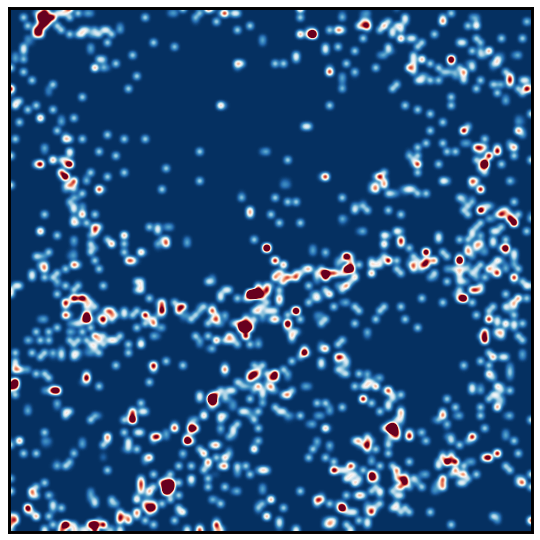

-1.0 103.50922 3.9665277 -0.005235242
-1.0 11.0
10.108
6.80e+00, 3.40e-03
p: (29289, 3)
gal_field: (1250, 1250, 1250)


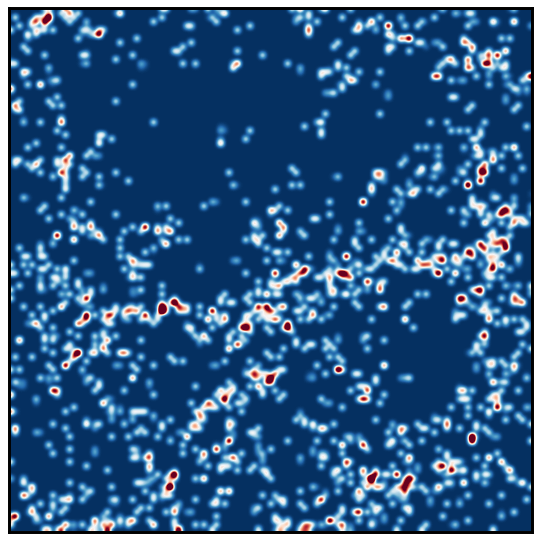

-1.0 45.25326 3.2834692 0.025933
-1.0 11.0
10.108
6.80e+00, 6.80e-03
p: (58581, 3)
gal_field: (1250, 1250, 1250)


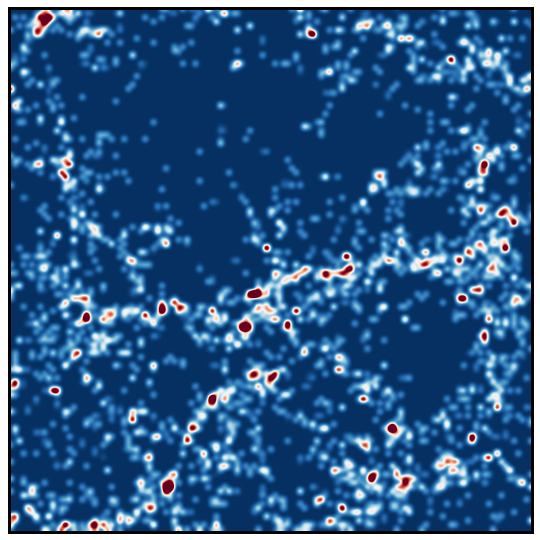

-1.0 52.669376 2.9313874 0.01034807
-1.0 11.0


In [15]:
delta_g, delta_g_box = dict(), dict()
d = 2 # factor to zoom into box
for color in ['red', 'blue', 'total']:
    gal_field, delta_g_box[color] = make_gal_mesh(color, d)
    delta_g[color] = plot_gal_mesh(gal_field, title = 'galaxy')

### Visualize the Lagrangian component fields

In [16]:
def fieldread_mpi_reverse(array, f, nmesh, rank, print_bool = True):
    '''
    Loads in a (pre-chunked) numpy array into an nbodykit complex field.

    Inputs:
    array - the field in question, [N, N, N]
    pm - the particlemesh object 
    rank - the MPI rank of this process

    Outputs:
    f - realfield locally held in rank
    knorms - array of |k| that will be hosted in this rank.
    '''
    
    Nx, Ny, Nz = [round(i) for i in nmesh/np.array(array.shape)] # gets the factor that each dimension is reduced by when chunking
    if print_bool == True:
        print('array.shape', array.shape, 'rank:', rank)
        print('nmesh: %i'%(nmesh), 'rank:', rank)
        print('Nx, Ny, Nz: %i %i %i'%(Nx, Ny, Nz), 'rank:', rank)

    Ni = rank//Ny
    if print_bool == True:
        print('Ni:', Ni, 'rank:', rank)

    Nj = (rank)%Ny
    if print_bool == True:
        print('Nj:', Nj, 'rank:', rank)
    
    x0 = int(np.floor(Ni*nmesh/Nx))
    x1 = int(np.floor((Ni+1)*nmesh/Nx))
    y0 = int(np.floor(Nj*nmesh/Ny))
    y1 = int(np.floor((Nj+1)*nmesh/Ny))
    
    if print_bool == True:
        print('f:', np.shape(f), 'rank:', rank)
        print(x0, x1, y0, y1)
        print('f chunk:', np.shape(f[x0:x1, y0:y1,:]), 'rank:', rank)

    f[x0:x1, y0:y1,:] = array # manually chunk the box and save it to the chunk we're on
    
    return f, [Nx, Ny, Nz]

In [17]:
def plot_lagfields_fig(home, weight, z, D, Nmesh = Nmesh, Ndown = Ndown, Lbox = 205, cmap = cmap, title = ['$\delta_m$', 
                                                                                                       '$\mathcal{O}_\delta$', 
                                                                                                       '$\mathcal{O}_{\delta^2}$', 
                                                                                                       '$\mathcal{O}_{s^2}$', 
                                                                                                      r'$\mathcal{O}_{\nabla^2}$', 
                                                                                                       '$\mathcal{O}_{\delta^3}$']):

    res = Nmesh//Ndown
    
    comm = MPI.COMM_WORLD 
    pm = pmesh.pm.ParticleMesh([Nmesh, Nmesh, Nmesh], Lbox, dtype='float32', resampler='cic', comm=comm)
    f = pm.create(type='real')
    
    lagfields = glob(home + '/lagfield/latetime_weight_'+str(weight)+'_5000_1250_z'+str(z)+'*')
    for rank in range(len(lagfields)):
        lagfield = home + '/lagfield/latetime_weight_'+str(weight)+'_5000_1250_z'+str(z)+'_rank'+str(rank)+'.npy'
        f, [Nx, Ny, Nz] = fieldread_mpi_reverse(np.load(lagfield), f, Nmesh, rank, print_bool = False)
    
    f_plot_box = downsample(f*D)                                                               # downsampled, but not averaged over
    f_plot = np.sum(f_plot_box[:,:,:int(res/4)], axis = 2)[:int(res/d),:int(res/d)]/int(res/4) # averaged over
    image = plt.imshow(f_plot, vmin = -1, vmax = 11, cmap = cmap, interpolation = 'bicubic') 
    plt.xticks([])
    plt.yticks([])
    vmin, vmax = image.get_clim()  
    print(vmin, vmax, vmax-vmin)
    print(np.min(f_plot.ravel()), np.max(f_plot.ravel()), np.std(f_plot),np.mean(f_plot))

    return image, f_plot, f_plot_box

-1.0 11.0 12.0
-0.8540656 31.279398 1.2896762 0.0067616953


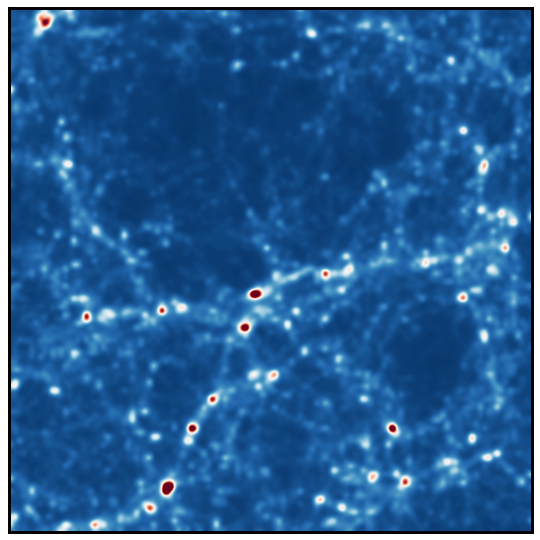

-1.0 11.0 12.0
-0.8540656 31.279398 1.2896762 0.0067616953
-1.0 11.0 12.0
-1.2090307 67.80681 2.200744 0.008234555


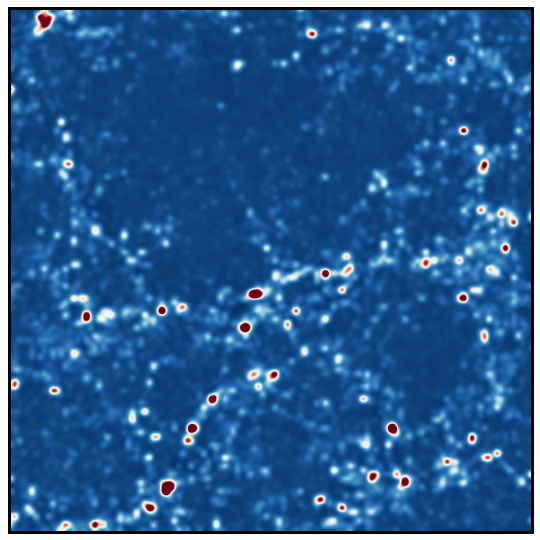

-1.0 11.0 12.0
-1.2090307 67.80681 2.200744 0.008234555
-1.0 11.0 12.0
-4.836923 75.42505 1.961675 0.013432799


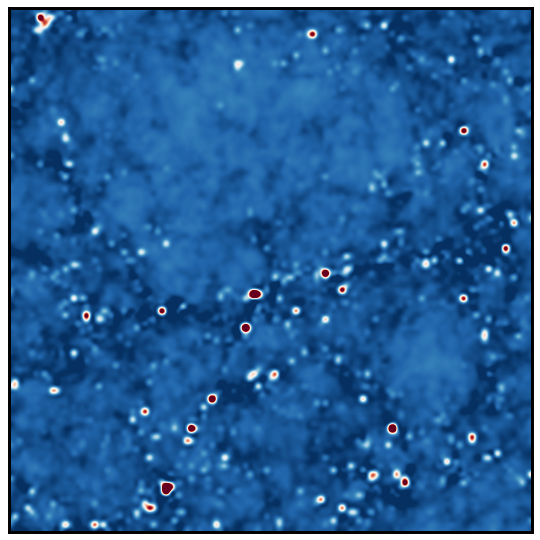

-1.0 11.0 12.0
-9.673846 150.8501 3.92335 0.026865598
-1.0 11.0 12.0
-12.116485 14.825452 0.73330563 0.011988506


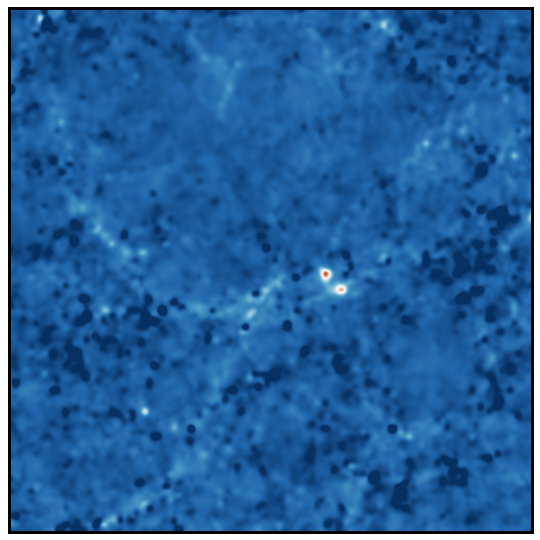

-1.0 11.0 12.0
-12.116485 14.825452 0.73330563 0.011988506
-1.0 11.0 12.0
-1.4921895 8.766305 0.48898146 0.00041705676


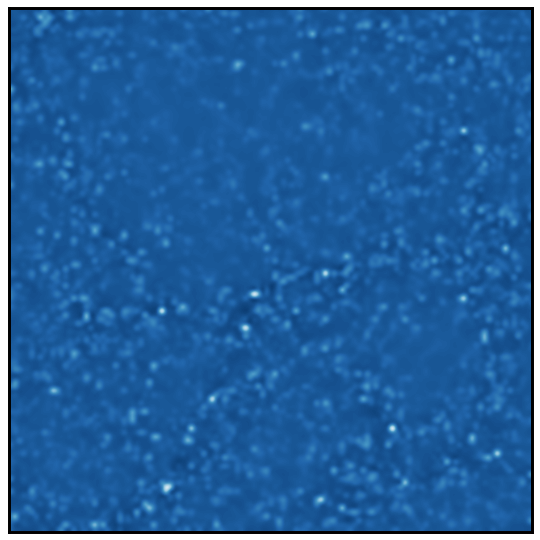

-1.0 11.0 12.0
-8.766305 1.4921895 0.48898146 -0.00041705676
-1.0 11.0 12.0
-11.937634 51.83804 1.5140283 -0.014202909


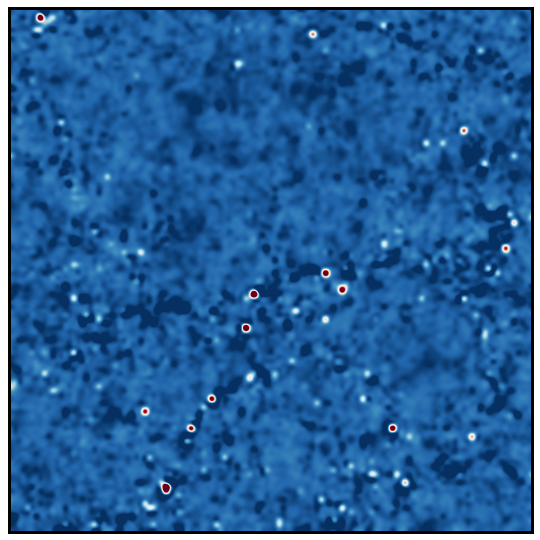

-1.0 11.0 12.0
-71.6258 311.0282 9.084169 -0.08521745


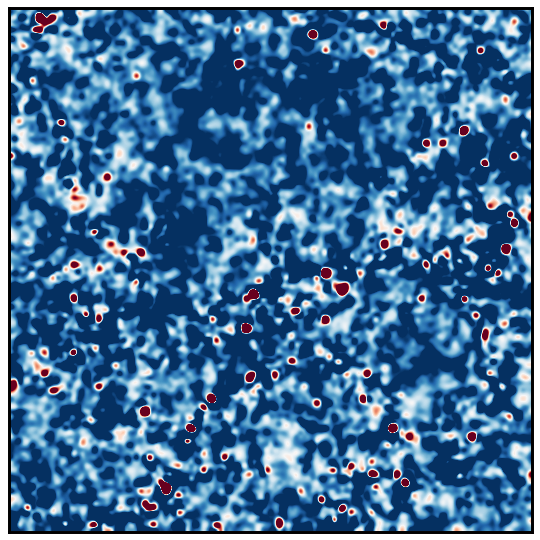

In [18]:
home = '/oak/stanford/orgs/kipac/users/mahlet/'
z, D = 0.5,75.49148345407697 # growth factor at z (computed using pyccl)
O_i_box =[]
for weight, vmin, vmax, power, factor in zip([0, 1, 2, 3, 4, 5], [-800, -1, 0, 0, 0, 0], [7000, 70, 5, 1, 10, 1], 
                                     [0, 1, 2, 2, 1, 3],[1,1,1/2,1,-1,1/6]): # weight each field by a factor for visualization purposes only
    
    image, f, f_box = plot_lagfields_fig(home+'TNG300-1', weight, z, D**power*factor)
        
    plt.savefig(home+'bias/figures/Figure1_latetime_weight_'+str(weight)+'_z'+str(z)+'.pdf', dpi = 300, bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    image, f, f_box = plot_lagfields_fig(home+'TNG300-1', weight, z, D**power) # recompute and save the fields without the additional factor
    O_i_box.append(f_box)

### Visualize the stochasticity field

(40, 5)
[ 1.          0.79381394  0.17100388 -0.17849821  1.84217834 -0.01430634]


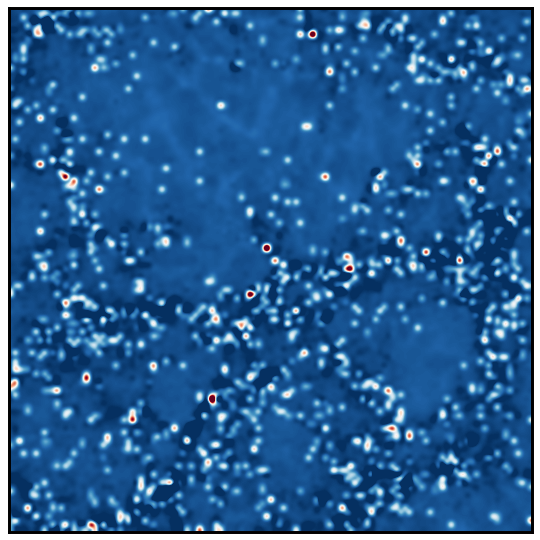

-34.95783226112666 46.514722660781004 2.3952543605891354 -0.02143868457736107
-1.0 11.0
(40, 5)
[ 1.          0.25193936 -0.30868125  0.25727141 -2.04243231 -0.10692017]


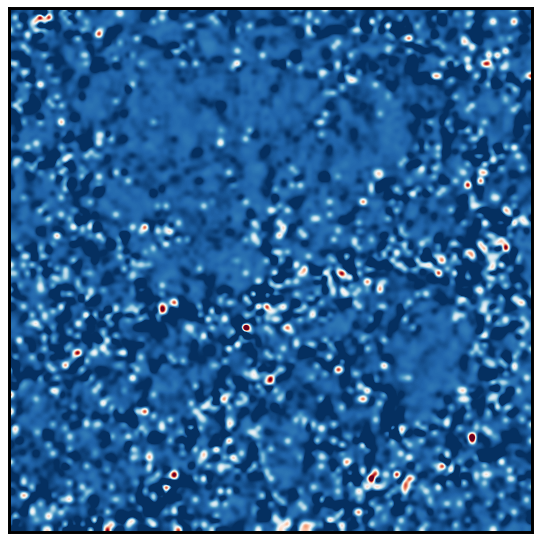

-16.226323007207906 43.1464359518103 2.725421609252871 0.012342032142540182
-1.0 11.0
(40, 5)
[ 1.          0.52289057 -0.06882641  0.0393755  -0.1000264  -0.06061088]


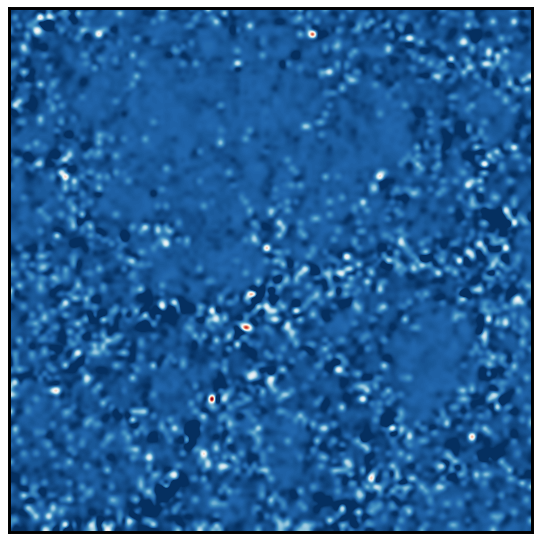

-13.941103816255852 27.169724855989298 1.60518595601075 -0.004549221782177521
-1.0 11.0


In [19]:
k1_idx = np.load(home + 'TNG_bias/sanity_check/k1_idx.npy')
delta_m, epsilon, delta_m_box, epsilon_box = dict(), dict(), dict(), dict()
res = Nmesh/Ndown
for color in ['red', 'blue', 'total']:
    
    delta_m[color] = np.zeros(np.shape(delta_g[color]))
    delta_m_box[color] = np.zeros(np.shape(delta_g_box[color]))
    biasval = np.load(home + 'TNG_bias/scripts/mpibiasval_TNGhod_z'+str(z)+'_Ndown1_nbias5_'+color+'_'+
                                  density+'.npy')
    print(biasval.shape)
    b_i=np.append([1],biasval[k1_idx])
    print(b_i)
    
    for i in range(len(b_i)):
        delta_m_box[color]+=O_i_box[i]*b_i[i]
        
    epsilon_box[color] = delta_g_box[color]-delta_m_box[color]
    plot_gal_mesh(np.sum(epsilon_box[color][:,:,:int(res/4)], axis = 2)[:int(res/d),:int(res/d)]/int(res/4), title = 'epsilon')

### Sanity check the stochasticity power spectrum

In [20]:
def CompensateCICAliasing(w, v):
    """
    Return the Fourier-space kernel that accounts for the convolution of
        the gridded field with the CIC window function in configuration space,
            as well as the approximate aliasing correction
    From the nbodykit documentation.
    """
    
    for i in range(3):
        wi = w[i]
        v = v / (1 - 2. / 3 * np.sin(0.5 * wi) ** 2) ** 0.5
    return v

In [21]:
def power_spectrum_err(f, color, z=z, sfr_tng = sfr_tng, sm_tng = sm_tng, pos_tng = pos_tng, density = density, Nmesh = Nmesh, Lbox = Lbox, linestyle = '-', linewidth = 5, alpha = 1): #sm

    ssfr_cut, sm_cut, cut_red, ssfr, red_ind_tng = cuts_z(z, color, density, 'TNG', sfr_tng, sm_tng)

    res = Nmesh/Ndown
    hodslice = pos_tng[z][red_ind_tng]
    
    pm = pmesh.pm.ParticleMesh([res, res, res], Lbox, dtype='float32', resampler='cic', comm=comm)
    
    # initialize a RealField
    gal_field = pmesh.pm.RealField(pm)
    gal_field[...]=f[color]
    
    # Create the FFTPower objects
    lin_pk = FFTPower(gal_field.r2c(), '1d', kmin = 1e-5)

    # k arrays are set like this
    kvals = lin_pk.power['k'] # let's ignore the artificial zero k value

    # Plot the P(k)
    plt.loglog(kvals, lin_pk.power['power'].real*len(hodslice)/Lbox**3, linestyle = linestyle, 
                   linewidth = linewidth, alpha = alpha) # lin_pk.power['power'].real[1:]
    plt.xlim(kvals[0], kvals[-1])
    
    plt.axhline(1, ls = "--", linewidth = 2.5, alpha = 0.5, color = 'grey')
    plt.ylabel('P(k)')
    plt.xlabel('k')

    # compare to saved nperr
    hodtype = 'TNG'
    perr = np.load(home + 'TNG_bias/scripts/mpiksumperr_'+hodtype+'hod_z'+str(z)+'_kmax0.20_Ndown1_nbias5_' +
                                        color+'_'+density+'.npy')
    kvals = np.load(home + 'TNG_bias/scripts/mpikvals_'+hodtype+'hod_z'+str(z)+'_Ndown1_nbias5_'+color+'_'+density+
                    '.npy')
    nbar = np.load(home + 'TNG_bias/scripts/mpinbar_' + hodtype + 'hod_z' + str(z) + '_Ndown1_nbias5_' + color +
                            '_'+density+'.npy')
    plt.semilogx(kvals, perr*nbar)
    plt.show()

10.108
6.80e+00, 3.40e-03


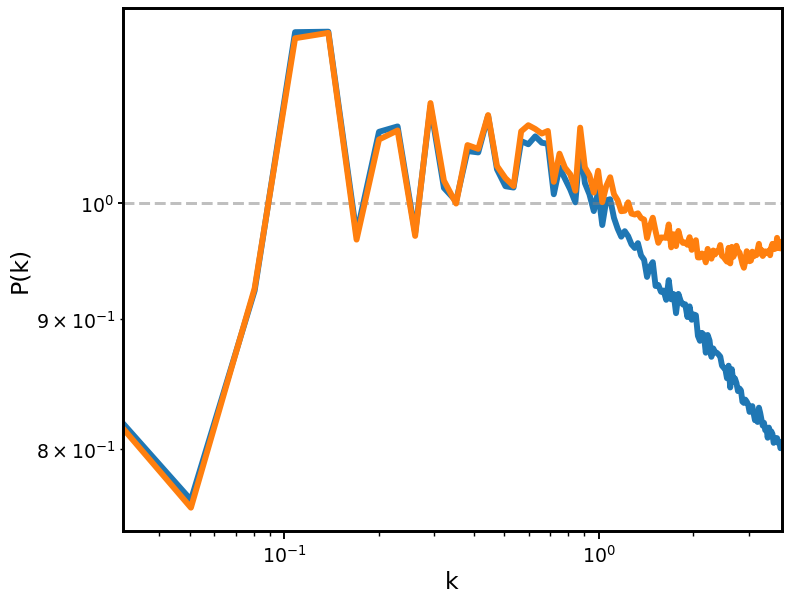

In [22]:
power_spectrum_err(epsilon_box, 'blue')

# Figure 2: Try plotting a 2D histogram
### Pick a colormap

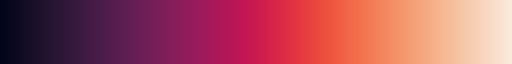

In [23]:
cmap = sns.color_palette("rocket", as_cmap = True)
cmap

### Define a function

In [24]:
def plot_prep(m, sfr, m_cut, bins_x, bins_y):
    
    m_log, sfr_log = np.log10(m), np.log10(sfr) 
    m_filter = np.where(m > 10**m_cut)[0]
    xbins = np.logspace(min(m_log[m_filter]), max(m_log), bins_x)
    ybins = np.logspace(min(sfr_log[m_filter]), max(sfr_log), bins_y)
    h, xedges, yedges = np.histogram2d(m, sfr, bins = [xbins, ybins])
    vmax = h.ravel().max()

    xlim, ylim = (xbins[0], xbins[-1]), (ybins[0], ybins[-1])
    return [m, sfr, xbins, ybins], xlim, ylim, vmax

def plot_final(params, xlim, ylim, vmax, ax, cmap, xlabel = None, ylabel = None, d = 4, legend = False):
    
    m, sfr, xbins, ybins = params
    h, xedges, yedges, image = ax.hist2d(m, sfr, bins = [xbins, ybins], cmap = cmap, norm = LogNorm(vmax = vmax), cmin = 1)
    print(min(xbins), min(ybins))
    
    ax.set_xlim(xlim) 
    ax.set_ylim(ylim)
    ax.set_xscale('log')
    ax.set_yscale('log')

    # set labels
    if xlabel != None:
        ax.set_xlabel(xlabel)
    else: 
        ax.set_xticks([])
    if ylabel != None:
        ax.set_ylabel(ylabel +'SFR [year$^{-1}]$')
    else: 
        ax.set_yticks([])
    if legend == True:
        ax.legend()
        
    return image

In [25]:
cmap_red = plt.get_cmap('Reds')(np.linspace(0.333, 0.999, 4))
cmap_blue = plt.get_cmap('Blues')(np.linspace(0.333, 0.999, 4))
cmap_total = plt.get_cmap('Purples')(np.linspace(0.333, 0.999, 4))
color_red = cmap_red[1] 
color_blue = cmap_blue[1] 
color_total = cmap_total[1] 

10.396
6.50e+00, 3.25e-03
vmax: 965.0
5000006556.510918 1.8834220704202856e-26
10.396
1.30e+00, 6.50e-04
10.534
6.50e+00, 3.25e-03
vmax: 86.0
5000063997.46144 2.6073120297799102e-24
10.534
1.30e+00, 6.51e-04
10.145
3.90e+00, 1.95e-03
vmax: 173.0
5000066757.202146 4.222360328519094e-25
10.145
3.90e+00, 1.95e-03
10.213
3.90e+00, 1.95e-03
vmax: 45.0
5000042038.06595 5.608343558498605e-25
10.213
3.90e+00, 1.95e-03


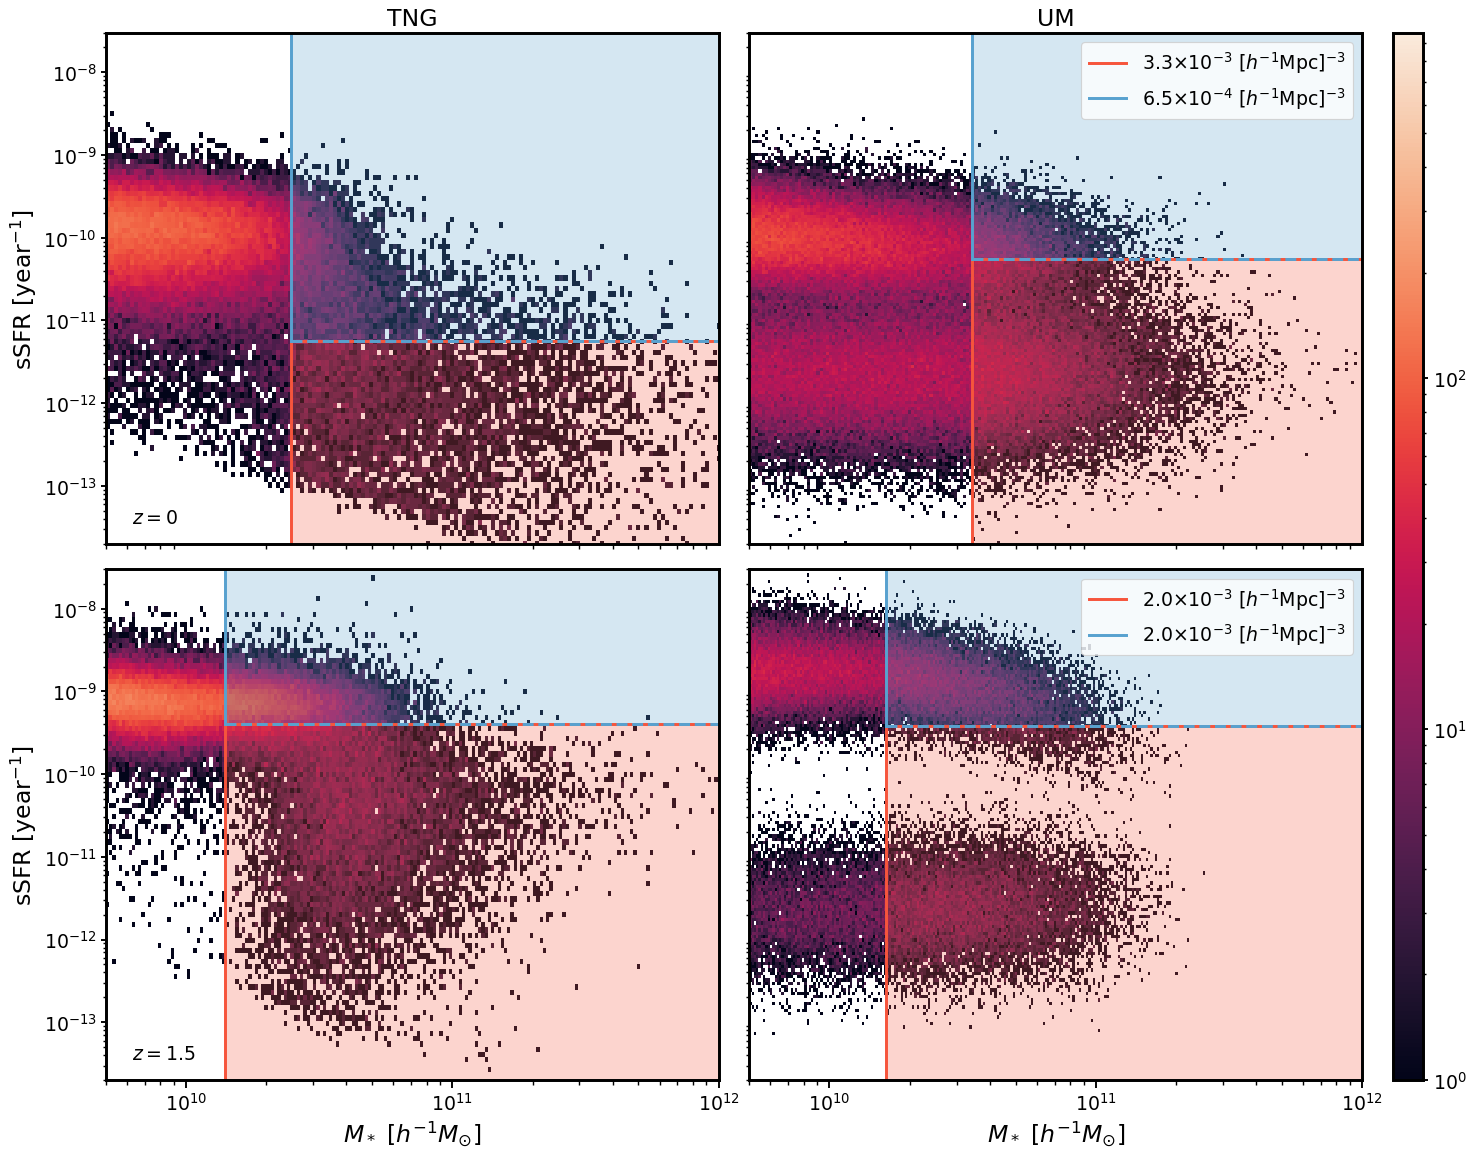

In [26]:
m_cut, bins_x, bins_y, density = np.log10(5e9), 200, 600, 'medium'
vmax = 965 

# plot!
fig = plt.figure(figsize = (20, 16))
gs = gridspec.GridSpec(3, 5, width_ratios = [1, 0.05, 1, 0.05, 0.05], height_ratios = [1, 0.05, 1])

zvec, j, xlabel = [0,1.5], [0, 2], [None, '$M_*$ $[h^{-1}M_{\odot}]$']
for i in range(len(zvec)):

    ssfr_cut, sm_cut, cut, ssfr_tng, ind = cuts_z(zvec[i], 'red', density, 'TNG', sfr_tng, sm_tng)
    params4, xlim4, ylim4, vmax4 = plot_prep(sm_tng[zvec[i]], ssfr_tng, m_cut, bins_x, bins_y)
    ax = fig.add_subplot(gs[j[i],0])
    print('vmax:', vmax4)
    xlim_sm = np.array((np.log10(5e9), np.log10(1e12))) # 8
    ylim_ssfr = np.array((np.log10(2e-14), np.log10(3e-8))) 
    image4 = plot_final(params4, 10**xlim_sm, 10**ylim_ssfr, vmax, ax, cmap = cmap, xlabel = xlabel[i], 
                        ylabel = 's') 
    
    # try making cuts for red gals
    xlim4, ylim4 = 10**xlim_sm, 10**ylim_ssfr
    xdiff, ydiff = np.diff(np.log10(xlim4)), np.diff(np.log10(ylim4))
    ax.axhline(y = 10**ssfr_cut, xmin = (sm_cut-np.log10(xlim4[0]))/xdiff[0], linewidth = 2.5, color = color_red, 
               label = "{:.1e}".format(cut) + ' $(h^{-1}\mathrm{Mpc})^{-3}$')
    ax.axvline(x = 10**sm_cut, ymax = (ssfr_cut-np.log10(ylim4[0]))/ydiff[0], linewidth = 2.5, color = color_red)
    ax.text(x = 1.25e9*5, y = 2e-14*2/1.12468307335954, s = '$z = $'+str(zvec[i]), fontsize = 16)
    ax.fill_between(np.logspace(sm_cut, 13), [10**ssfr_cut]*50, [1e-15]*50, color = color_red, alpha = 0.25)
    
    # try making cuts for blue gals
    ssfr_cut, sm_cut, cut, ssfr_tng, ind = cuts_z(zvec[i], 'blue', density, 'TNG', sfr_tng, sm_tng)
    ax.axhline(y = 10**ssfr_cut, xmin = (sm_cut-np.log10(xlim4[0]))/xdiff[0], linewidth = 2.5, color = color_blue, 
               linestyle = '--')
    ax.axvline(x = 10**sm_cut, ymin = (ssfr_cut-np.log10(ylim4[0]))/ydiff[0], linewidth = 2.5, color = color_blue,
               label = "{:.1e}".format(cut) + ' $(h^{-1}\mathrm{Mpc})^{-3}$')
    ax.fill_between(np.logspace(sm_cut, 13), [10**ssfr_cut]*50, [1e-6]*50, color = color_blue, alpha = 0.25)
    if i == 0:
        ax.set_title('TNG')
        ax.set_xticks([])
    gs.update(wspace = 0, hspace = 0)
    
    ssfr_cut, sm_cut, cut, ssfr_um, ind = cuts_z(zvec[i], 'red', density, 'UM', sfr_um, sm_um)
    params4, xlim4, ylim4, vmax4 = plot_prep(sm_um[zvec[i]], ssfr_um, m_cut, bins_x, bins_y)
    print('vmax:', vmax4)
    
    ax = fig.add_subplot(gs[j[i],2])
    
    image4 = plot_final(params4, 10**xlim_sm, 10**ylim_ssfr, vmax, ax, cmap = cmap, xlabel = xlabel[i]) 
    
    # try making cuts for red gals
    xlim4, ylim4 = 10**xlim_sm, 10**ylim_ssfr
    xdiff, ydiff = np.diff(np.log10(xlim4)), np.diff(np.log10(ylim4))
    ax.axhline(y = 10**ssfr_cut, xmin = (sm_cut-np.log10(xlim4[0]))/xdiff[0], linewidth = 2.5, color = color_red, 
               label = "{:.1e}".format(cut)[:3]+r'$\times 10^{-'+'{:.1e}'.format(cut)[-1]+ r'}$ $[h^{-1}\mathrm{Mpc}]^{-3}$')
    ax.axvline(x = 10**sm_cut, ymax = (ssfr_cut-np.log10(ylim4[0]))/ydiff[0], linewidth = 2.5, color = color_red)
    ax.fill_between(np.logspace(sm_cut, 13), [10**ssfr_cut]*50, [1e-15]*50, color = color_red, alpha = 0.25)

    # try making cuts for blue gals
    ssfr_cut, sm_cut, cut, ssfr, ind = cuts_z(zvec[i], 'blue', density, 'UM', sfr_um, sm_um)
    ax.axhline(y = 10**ssfr_cut, xmin = (sm_cut-np.log10(xlim4[0]))/xdiff[0], linewidth = 2.5, color = color_blue, 
               linestyle = '--')
    ax.axvline(x = 10**sm_cut, ymin = (ssfr_cut-np.log10(ylim4[0]))/ydiff[0], linewidth = 2.5, color = color_blue,
               label = "{:.1e}".format(cut)[:3]+r'$\times 10^{-'+'{:.1e}'.format(cut)[-1]+ r'}$ $[h^{-1}\mathrm{Mpc}]^{-3}$')
    ax.fill_between(np.logspace(sm_cut, 13), [10**ssfr_cut]*50, [1e-6]*50, color = color_blue, alpha = 0.25)
    ax.legend(loc = 'upper right')
    if i == 0:
        ax.set_title('UM')
        ax.set_xticks([])

fig.colorbar(image4, cax = fig.add_subplot(gs[:,-1]))
plt.savefig(home+'bias/figures/Figure2', dpi = 300, bbox_inches='tight')
plt.show()